# Comparaison cash versus scriptural

Objectif : Comparer au niveau de la requête francophone les tweets qui concernent le cash versus le scriptural. 

### Pre-process

In [1]:
# Import librairies 
from functools import reduce
import random
import re
import time
from gensim.utils import deaccent
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = None
pd.options.display.max_columns = 30
#from wordcloud import WordCloud
import wordcloud
from nltk.corpus import stopwords
import seaborn as sns
import os

# import functions
def display_several_wordcloud(cash_dic, title):
    cash_dic = list(cash_dic)
    n_components=len(list(cash_dic))
    fig=plt.figure(figsize=(20,30))
    j = np.ceil(n_components/2)
    for t in range(n_components):
        i=t+1
        
        word = list(cash_dic)[i-1]
        kw_cash = cash_series.loc[cash_series[word]==True]
        clean_tweet_string = ' '.join(list(kw_cash['clean_tweet'].values))
        clean_tweet_string = ' '.join([word for word in clean_tweet_string.split() if word not in (stop_words)])
        
        wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
        wordcloud.generate(clean_tweet_string)
        
        plt.subplot(j, 2, i).set_title("Topic " + str(t+1) + " " +word)
        plt.plot()
        plt.imshow(wordcloud.to_image())
        plt.axis("off")
    fig.suptitle(title)
    plt.show()
    
def yearmon(dts):
    try:
        y = dts.year.astype(str)
    except AttributeError:
        y = str(dts.year)
    try:
        m = dts.month.astype(str).to_series().apply(lambda s: s.zfill(2))
    except AttributeError:
        m = str(dts.month).zfill(2)
    
    ym = y + "-" + m
    return ym

def groupe_graph(groupe_1, rolling=15): #plot_groupe
    max_count = 0
    for word in groupe_1:
        kw_cash = cash_series.loc[cash_series[word] == True]
        monthly_count = kw_cash.resample("D").size().rolling(rolling).mean()
        max_count = max(max_count, max(monthly_count)) # for ymax of fill area
        ax = monthly_count.plot(figsize=(13, 7), label=word) 
    return(ax)

def get_groupe_aggregate(groupe, rolling=15): 
    max_count = 0
    counts = []
    for word in groupe:
        kw_cash = cash_series.loc[cash_series[word] == True]
        monthly_count = kw_cash.resample("D").size().rolling(rolling).mean()
        counts += [monthly_count]
    agg_count = reduce(lambda a, b: a + b, counts) / len(counts)
    #alt: pd.DataFrame(counts).mean(axis=1)

    return(agg_count)

In [2]:
# import parameters and data
SAVE_FIG = True 
path = os.chdir("/home/cash")
query_fr = '(espece OR especes OR espèce OR espèces OR billet OR billets OR piece OR pieces OR pièce OR pièces OR monnaie OR cash OR liquide OR retraits OR retrait OR distributeur OR distributeurs OR " DAB " OR guichet OR guichets OR carte OR cartes OR " CB " OR "sans contact" OR " visa " OR mastercard OR "cash back" OR " NFC " OR "Google Pay" OR "ApplePay" OR "Paylib" OR "Lydia" OR "Lyf Pay" OR "Alipay" OR "Samsung Pay" OR "Stocard Pay" OR "paiements mobiles" OR "chèques" OR chèque OR cheque OR cheques) AND (paiement OR paiements OR payer OR reglement OR reglements OR réglement OR réglements OR regler OR régler OR achat OR achats OR acheter OR retirer OR virement OR virements OR virer OR depense OR dépense OR dépenses OR depenses OR dépenser OR depenser)'

WHAT_CASH = ['espece',  'especes', 'billets', 'billet', 'piece', 'pieces', 'monnaie', 'cash',
             'liquide', 'retraits', 'retrait', 'distributeur', 'distributeurs', ' dab ', 'guichet', 'guichets'
            ]
HOW_CASH = ['paiement', 'paiements', 'payer', 'reglements', 'reglement', 'regler', 'achat',
            'achats', 'acheter', 'retirer', 'depenser', 'depense', 'depenses']
WHAT_CB = ['carte', 'cartes', ' cb ', 'sans contact', ' visa ', 'mastercard',
            'cash back', ' nfc ', 'google pay', 'applepay', 'paylib', 'lydia',
            'lyf pay"', 'alipay', 'samsung pay', 'stocard pay', 'paiements mobiles', 'chèques','cheques','cheque', 'chèque']
HOW_CB = ['paiement', 'paiements', 'payer', 'reglement', 'reglements', 'regler','achat', 'achats',
          'acheter', 'retirer', 'virement', 'virements', 'virer', 'depenser', 'depense', 'depenses']

df_cash = pd.read_pickle(f"/home/cash/output/cleaned_queries/with_geoloc/query_fr_cash_cleaned_geoloc.pickle")
df_cash["datetime"] = pd.to_datetime(df_cash["datetime"])
df_cash["created_at"] = df_cash["datetime"]
df_cash.set_index("datetime", inplace=True)

df_cb = pd.read_pickle(f"/home/cash/output/cleaned_queries/with_geoloc/query_fr_cb_cleaned_geoloc.pickle")
df_cb["datetime"] = pd.to_datetime(df_cb["datetime"])
df_cb["created_at"] = df_cb["datetime"]
df_cb.set_index("datetime", inplace=True)

df =  pd.concat([df_cash, df_cb], ignore_index = True)
df = df.drop_duplicates()
df["datetime"]= df["created_at"] 
df.set_index("datetime", inplace=True)

## Analyse et graphiques

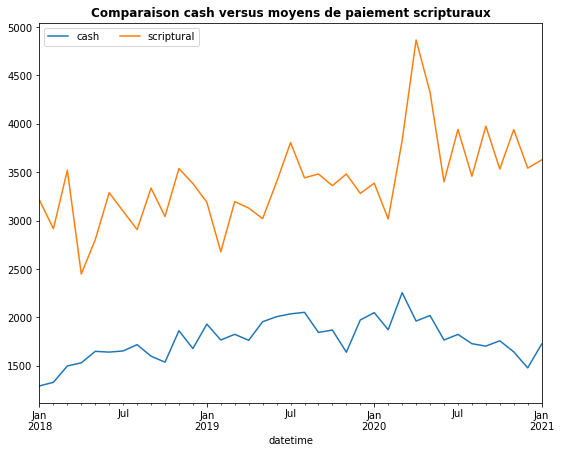

In [3]:
cash = df.clean_tweet.str.count('|'.join(WHAT_CASH)).resample("M").sum()
cb = df.clean_tweet.str.count('|'.join(WHAT_CB+ ["dematerialises?", "scripturaux", "scriptural"])).resample("M").sum()

ax = cash.plot(figsize=(9, 7), label = "cash")
ax = cb.plot(figsize=(9, 7),  label = "scriptural")

ax.set_title("Comparaison cash versus moyens de paiement scripturaux", fontweight="bold")
ax.legend(ncol=2, loc="upper left")

if SAVE_FIG:
    ax.figure.savefig("output/figs/comp_cash_scriptural/comp_cash_script.png")

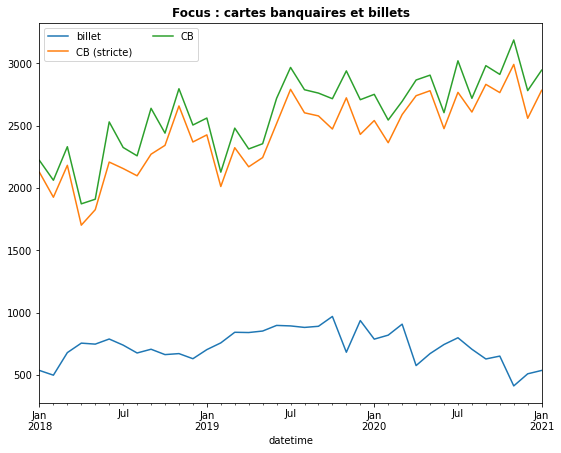

In [5]:
billet = df.clean_tweet.str.count("billets?").resample("M").sum()
carte = df.clean_tweet.str.count("cartes? | cb").resample("M").sum()
carte_plus = df.clean_tweet.str.count("cartes?| cb | mastercard | visa ").resample("M").sum()
ax = billet.plot(figsize=(9, 7),  label = "billet")
ax = carte.plot(figsize=(9, 7),  label = "CB (stricte)")
ax = carte_plus.plot(figsize=(9, 7),  label = "CB")
ax.set_title("Focus : cartes banquaires et billets", fontweight="bold")
ax.legend(ncol=2, loc="upper left")
if SAVE_FIG:
    ax.figure.savefig("output/figs/comp_cash_scriptural/focus_cb_billet.png")

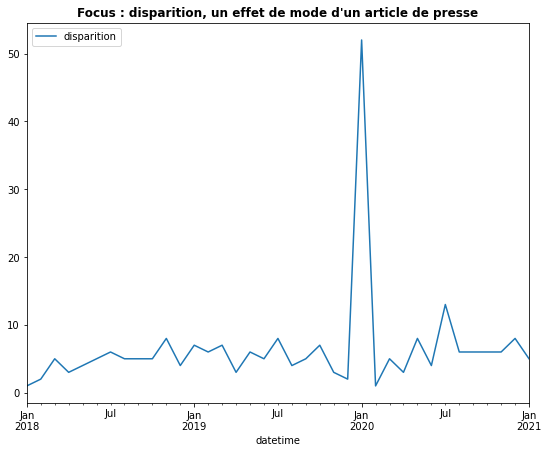

In [7]:
disparition = df.clean_tweet.str.count("disparition").resample("M").sum()
ax = disparition.plot(figsize=(9, 7),  label = "disparition")
ax.set_title("Focus : disparition, un effet de mode d'un article de presse", fontweight="bold")
ax.legend(ncol=2, loc="upper left")
if SAVE_FIG:
    ax.figure.savefig("output/figs/comp_cash_scriptural/disparition.png")

In [6]:
df[df.clean_tweet.str.contains("disparition")].loc["2020-01"].clean_tweet.sample(50).tolist()

['« la disparition du #cash  c est à terme la disparition de la #liberte » société sans cash=soumission au monopole du #lobby #bancaire   si #crise financière &amp; bancaire  notre défense en tant que citoyen ordinaire est de retirer notre argent  ds 1 sté sans cash  ça sera impossible',
 'disparition du cash   à l avenir  payer en espèces pourrait vous coûter plus cher   ///hsgsnjcl8e',
 'disparition du cash   à l avenir  payer en espèces pourrait vous coûter plus cher   ///partszgqm3',
 'disparition du cash   à l avenir  payer en espèces pourrait vous coûter plus cher   ///oynfgvhe6k via @mariannelemag',
 'je suis donc bien motivé à acheter toutes les cartes de type fée avant leur disparition du #jccpokémon  et maudire celui qui a eu cette idée mortifère   j en ai actuellement 75 sur 223  on verra jusqu où je vais monter ',
 'disparition du cash   à l avenir  payer en espèces pourrait vous coûter plus cher   ///xkjsvtnphi via @mariannelemag',
 'disparition du cash   à l avenir  payer

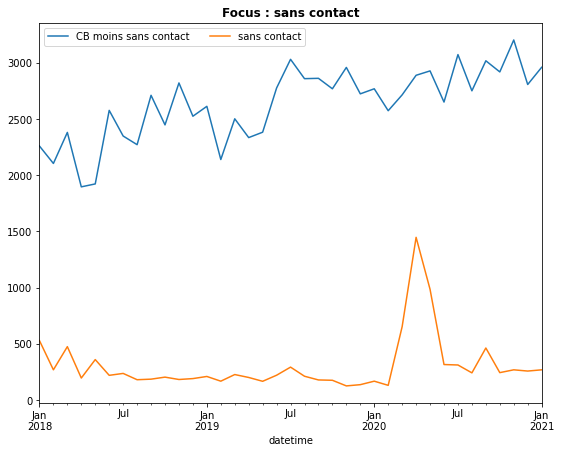

In [8]:
# Focus sans contact
cb_sans_contact = ['carte', 'cartes', ' cb ', ' visa ', 'mastercard']

sans_contact = df.clean_tweet.str.count("sans contact").resample("M").sum()
cb = df.clean_tweet.str.count('|'.join(cb_sans_contact+ ["dematerialises?", "scripturaux", "scriptural"])).resample("M").sum()
ax = cb.plot(figsize=(9, 7),  label = "CB moins sans contact")
ax = sans_contact.plot(figsize=(9, 7),  label = "sans contact")
ax.set_title("Focus : sans contact", fontweight="bold")
ax.legend(ncol=2, loc="upper left")
if SAVE_FIG:
    ax.figure.savefig("output/figs/comp_cash_scriptural/focus_sans_contact.png")

In [8]:
df[df.clean_tweet.str.contains("sans contact")].clean_tweet.sample(50).tolist()

['pourquoi les gens collent leur carte bancaire au terminal (parfois en la tordant méchant) pour du paiement *sans contact* ?',
 '@quibelog @lespoteauxcb @cedric672 @easyjet @misterfly_fr ça passe pas en paiement sans contact 🤷🏻\u200d♀️😂',
 '@tag_grenoble pourquoi pas mettre ce tpe dans les proximos ?   ///j9ms7hlvqg ça permettrais de payer les tickets plus facilement  et c est pas très cher (et le sans contact serait sympa sur les distributeurs des arrêts de tram…)',
 'payer sans contact avec son tel c est le feux 😍😍',
 'a londres  des bornes de paiement sans contact pour les artistes de rue   ///4be8qfd9oi',
 '@akemiyano @gaeko_san même le paiement sans contact les caissiers ils sont en pls quand ils te voient le faire car ouais t as pas utilisé la puce sale thug',
 'coronavirus   l oms recommande d opter pour les paiements sans contact   ///szd0i12iiq',
 'des expériences de paiement plus flexibles  comme les technologies sans contact et des systèmes d encaissement mobiles  font part

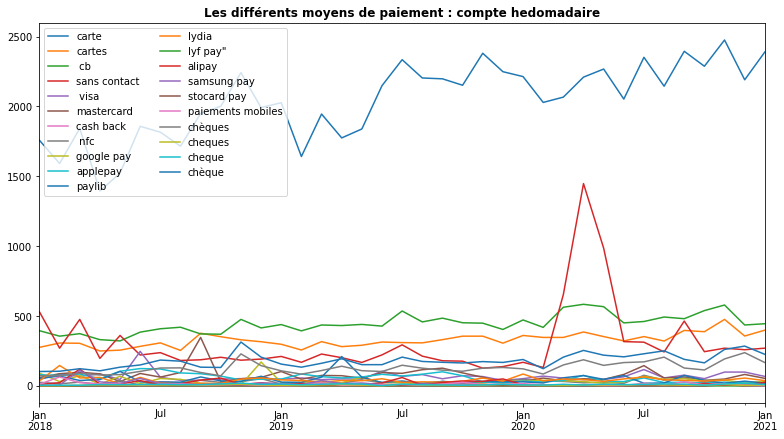

In [9]:
for kw in WHAT_CB : 
    kw_data = df.clean_tweet.str.count(kw).resample("M").sum()
    ax = kw_data.plot(figsize=(13, 7), label=kw)
ax.set_title("Les différents moyens de paiement : compte hedomadaire", fontweight="bold")
ax.set_xlabel("")
ax.legend(ncol=2, loc="upper left")

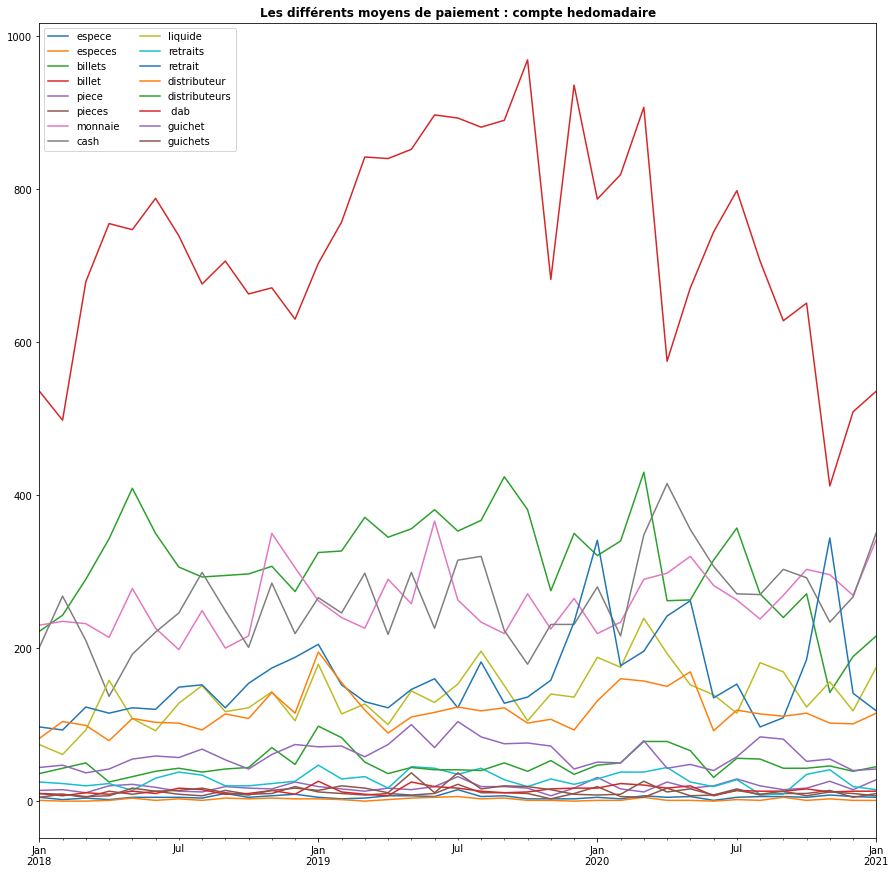

In [10]:
for kw in WHAT_CASH : 
    kw_data = df.clean_tweet.str.count(kw).resample("M").sum()
    ax = kw_data.plot(figsize=(15, 15), label=kw)
ax.set_title("Les différents moyens de paiement : compte hedomadaire", fontweight="bold")
ax.set_xlabel("")
ax.legend(ncol=2, loc="upper left")

## Comp des differents moyens de paiement

In [11]:
moy_paiement_kw = {"cb" : "cartes?| cb |sans contact|visa|mastercard", 
          "paiement_mobile" : "google pay|applepay|paylib|lydia|lyf pay|alipay|samsung pay|stocard pay|paiements? mobiles?", 
          "cheque" : "ch(e|è)ques?", 
          "cash" : "especes?|billets?|pieces?|monnaie|cash|liquide"}

In [13]:
moy_paiement = pd.DataFrame({ k : df['clean_tweet'].str.contains(v, na = False) for k, v in moy_paiement_kw.items()})
moy_paiement = moy_paiement.assign(clean_tweet= df.clean_tweet, datetime = df.created_at, 
                                   created_at = df.created_at)
moy_paiement.set_index("datetime", inplace=True)

/home/cash/.local/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


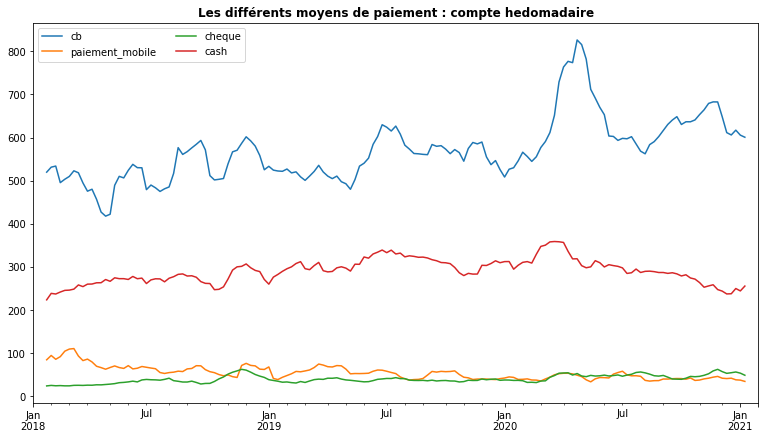

In [14]:
for kw in moy_paiement_kw :
    kw_moy_paiement = moy_paiement[moy_paiement[kw] == True].resample("W").size().rolling(window = 7, center = True).mean()
    #max_count = max(max_count, max(monthly_count)) # for ymax of fill area
    ax = kw_moy_paiement.plot(figsize=(13, 7), label=kw)

ax.set_title("Les différents moyens de paiement : compte hedomadaire", fontweight="bold")
ax.set_xlabel("")
ax.legend(ncol=2, loc="upper left")

if SAVE_FIG:
    ax.figure.savefig("output/figs/comp_cash_scriptural/diff_moy_paiement.png")

In [14]:
kw = "paiement_mobile"
print(moy_paiement[(moy_paiement[kw]==True)].loc['2018-11-01':'2018-11-30'].clean_tweet.sample(50))
#essor de lyf pay avec entrée de casino au capital de Lyf Pay

datetime
2018-11-19 18:34:09                                                                         5€ offerts pour votre inscription sur #lyfpay avec mon code 1h6yf  a utiliser dans l une des enseignes partenaires  paiement mobile &amp; rbst entre amis avec toutes nos cartes de fid et tout ça réuni ds l app @lyfpay  pour télécharger l app c est par ici ➡️   ///sgazdro6q6
2018-11-01 15:32:36                                                                                pourquoi l arrivée des technologies nfc prend-elle autant de temps en france ? paiement mobile samsung pay  google pay  impossibilité d utiliser le sans contact de sa cb sur les bornes navigo pour remplacer le billet de métro    tout ça fonctionne bien en angleterre 
2018-11-05 06:29:04                                                                                                                                                                                                                                              

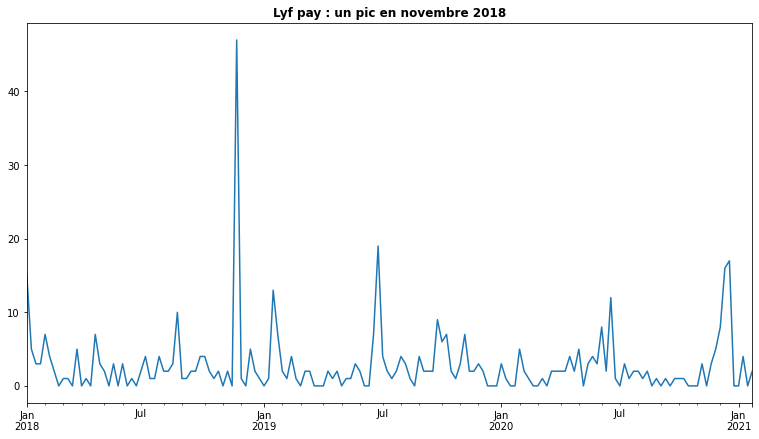

In [15]:
kw = "paiement_mobile"
kw_spec="lyf pay"
lyf_pay = moy_paiement[(moy_paiement[kw]==True) & (moy_paiement.clean_tweet.str.contains(kw_spec, na = False))].resample("W").size()
ax = lyf_pay.plot(figsize=(13, 7))
ax.plot(figsize=(13, 7))
ax.set_title("Lyf pay : un pic en novembre 2018", fontweight="bold")
ax.set_xlabel("")
#essor de lyf pay avec entrée de casino au capital de Lyf Pay
if SAVE_FIG:
    ax.figure.savefig("output/figs/comp_cash_scriptural/lyf_pay.png")